# Install python 3.11 on Colab

In [1]:
!sudo apt-get update
!sudo apt-get install python3.11 python3.11-dev python3.11-venv
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --config python3  # Then choose the number corresponding to Python 3.11 (e.g. 2)

# From the top menu of Colab, go to:
# Runtime → Restart runtime

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,768 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [1]:
import sys
print(sys.version)  # Should show Python 3.11.x

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


# Unzip on Colab

In [2]:
import zipfile
import os

# Replace 'your_file.zip' with the name of your uploaded ZIP file
zip_file_name = '/content/archive.zip'
extract_folder = '/content'

# Create a directory to extract the files
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f'Files extracted to: {extract_folder}')

Files extracted to: /content


# Phase 1

In [1]:
import re, pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
from tqdm.auto import tqdm
from scipy.sparse import csr_matrix
!pip install gensim
from gensim.models import Word2Vec

import nltk
nltk.download('stopwords')
nltk.download('wordnet')    # for lemmatizer
nltk.download('omw-1.4')    # To support multilingual

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
INPUT_CSV = "ecommerceDataset.csv"
OUTPUT_CSV = "ecommerceDataset_clean.csv"

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
NON_ALPHA_RE = re.compile(r"[^a-zA-Z ]+")
TOK_RE = re.compile(r"[a-z]{3,}")  # Words with at least 3 letters
MULTI_SPACE = re.compile(r"\s{2,}")


def clean_text(text: str) -> str:
    """Simple regex-based tokenizer"""
    if not isinstance(text, str):
        return ""
    text = URL_RE.sub(" ", text.lower())
    text = HTML_RE.sub(" ", text)
    text = NON_ALPHA_RE.sub(" ", text)

    tokens = TOK_RE.findall(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


# ---------- process ----------
df = pd.read_csv(INPUT_CSV, header=None, names=["label", "text"], dtype=str)
df = df.dropna(subset=["label", "text"]).drop_duplicates()

tqdm.pandas(desc="Cleaning")
df["clean_text"] = df["text"].progress_apply(clean_text)

df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ تمیزسازی کامل شد؛ فایل ذخیره شد → {OUTPUT_CSV}")

df.head()  # Preview the first 5 lines

Cleaning:   0%|          | 0/27802 [00:00<?, ?it/s]

✅ تمیزسازی کامل شد؛ فایل ذخیره شد → ecommerceDataset_clean.csv


,label,text,clean_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch inch spec...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf textured modern art print framed painting ...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


# Phase 2

In [3]:
DATA_CLEAN = Path("ecommerceDataset_clean.csv")
VECTOR_SIZE = 100  # dimensionality for Word2Vec
MIN_COUNT = 2  # discard tokens seen < MIN_COUNT times (w2v)
WORKERS = 4  # CPU cores for Word2Vec

# Load cleaned data
print("Loading cleaned dataset…")
df = pd.read_csv(DATA_CLEAN)
texts = df["clean_text"].astype(str).tolist()
labels = df["label"].to_numpy()
print(f" ↳ {len(texts):,} documents")

# Tokenise by simple whitespace (already pre‑tokenised)
docs_tokens = [t.split() for t in texts]

# TF‑IDF (manual)
print("\nBuilding vocabulary…")
DF = Counter()  # document frequency
for tok_set in map(set, docs_tokens):
    DF.update(tok_set)

vocab = {tok: i for i, (tok, _) in enumerate(DF.items())}
V = len(vocab)
N = len(docs_tokens)
print(f" ↳ vocab size = {V:,}")

# Pre‑compute IDF vector: idf = log(N / df)
IDF = np.log(np.array([N / DF[tok] for tok in vocab], dtype=np.float32))

# Build sparse TF‑IDF matrix:
rows, cols, data = [], [], []
print("Computing TF‑IDF matrix…")
for doc_idx, tokens in enumerate(tqdm(docs_tokens)):
    TF = Counter(tokens)
    for tok, tf in TF.items():
        col = vocab[tok]
        rows.append(doc_idx)
        cols.append(col)
        data.append(tf * IDF[col])  # raw‑count TF × IDF

X_tfidf = csr_matrix((data, (rows, cols)), shape=(N, V), dtype=np.float32)
print(f" ↳ TF‑IDF matrix: {X_tfidf.shape}, nnz = {X_tfidf.nnz:,}")

# Word2Vec (gensim)
print("\nTraining Word2Vec model…")
w2v_model = Word2Vec(
    sentences=docs_tokens,
    vector_size=VECTOR_SIZE,
    window=5,
    min_count=MIN_COUNT,
    workers=WORKERS,
    epochs=10,
    sg=1,  # skip‑gram
)

print("Building document vectors…")
X_w2v = np.zeros((N, VECTOR_SIZE), dtype=np.float32)
for i, tokens in enumerate(docs_tokens):
    vectors = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    if vectors:
        X_w2v[i] = np.mean(vectors, axis=0)
    # else row remains zeros (OOV)
print(f" ↳ Word2Vec doc‑matrix: {X_w2v.shape}")

# Save artefacts
OUT_DIR = Path("vectorised")
OUT_DIR.mkdir(exist_ok=True)

np.save(OUT_DIR / "labels.npy", labels)
np.save(OUT_DIR / "X_w2v.npy", X_w2v)

np.savez_compressed(
    OUT_DIR / "X_tfidf.npz",
    data=X_tfidf.data,
    indices=X_tfidf.indices,
    indptr=X_tfidf.indptr,
    shape=X_tfidf.shape,
)
print("Saved vectors to ./vectorised/ …")

Loading cleaned dataset…
 ↳ 27,802 documents

Building vocabulary…
 ↳ vocab size = 58,116
Computing TF‑IDF matrix…


  0%|          | 0/27802 [00:00<?, ?it/s]

 ↳ TF‑IDF matrix: (27802, 58116), nnz = 1,409,072

Training Word2Vec model…
Building document vectors…
 ↳ Word2Vec doc‑matrix: (27802, 100)
Saved vectors to ./vectorised/ …


# Phase 3 and 4

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import load_npz
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib
import os

Loading vectorized data...

Evaluating TF-IDF vectors...

--- Logistic Regression ---
Train Accuracy: 0.9998
Test Accuracy: 0.9509
              precision    recall  f1-score   support

 Electronics       0.94      0.95      0.94      1271
   Household       0.97      0.98      0.98      1121
       Books       0.93      0.92      0.93      1057
    Clothing       0.96      0.95      0.95      2112

    accuracy                           0.95      5561
   macro avg       0.95      0.95      0.95      5561
weighted avg       0.95      0.95      0.95      5561


Saved TF-IDF Logistic Regression model to saved_models/logistic_regression_tfidf.joblib

Evaluating Word2Vec vectors...

--- Logistic Regression ---
Train Accuracy: 0.9265
Test Accuracy: 0.9283
              precision    recall  f1-score   support

 Electronics       0.96      0.92      0.94      1271
   Household       0.94      0.96      0.95      1121
       Books       0.91      0.90      0.91      1057
    Clothing       0.9

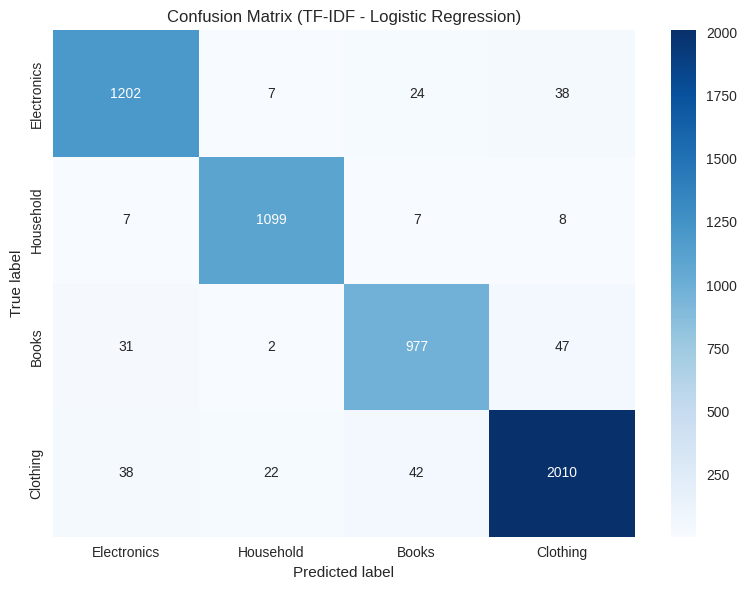

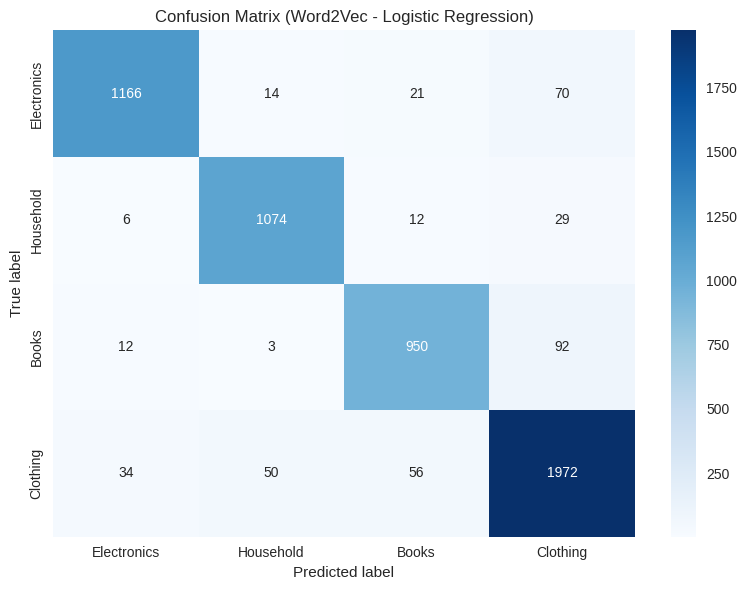


=== Final Results Summary ===

TF-IDF Results:

Logistic Regression:
Train Accuracy: 0.9998
Test Accuracy: 0.9509

Word2Vec Results:

Logistic Regression:
Train Accuracy: 0.9265
Test Accuracy: 0.9283

All results saved to files.
Saved all vectorization components


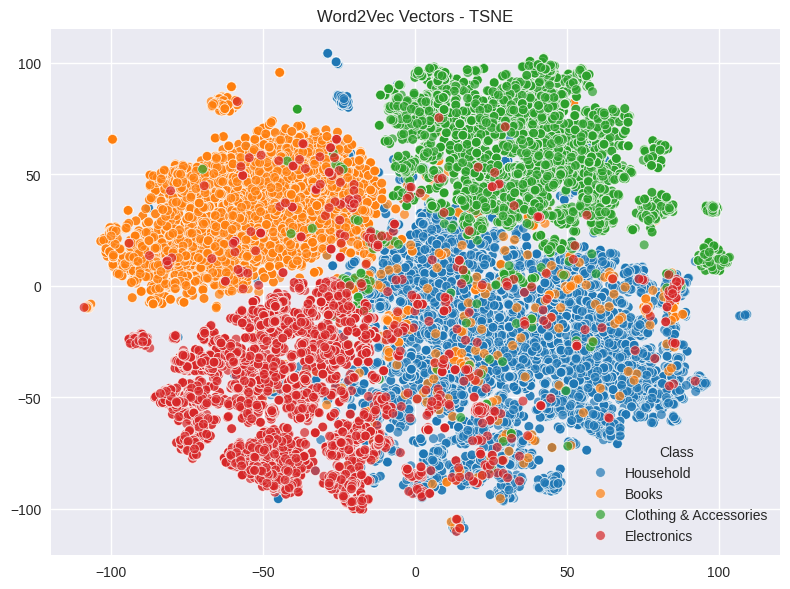


Sample indices predicted as 'Electronics': []


In [10]:
# Create directory for saving models
MODEL_DIR = Path("saved_models")
os.makedirs(MODEL_DIR, exist_ok=True)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Load vectorized data from Phase 2
print("Loading vectorized data...")
OUT_DIR = Path("vectorised")

# Load labels with allow_pickle=True
try:
    labels = np.load(OUT_DIR / "labels.npy", allow_pickle=True)
except Exception as e:
    print(f"Error loading labels: {e}")
    raise

# Load TF-IDF matrix
try:
    tfidf_data = np.load(OUT_DIR / "X_tfidf.npz")
    X_tfidf = csr_matrix((tfidf_data['data'], tfidf_data['indices'],
                        tfidf_data['indptr']), shape=tfidf_data['shape'])
except Exception as e:
    print(f"Error loading TF-IDF matrix: {e}")
    raise

# Load Word2Vec matrix
try:
    X_w2v = np.load(OUT_DIR / "X_w2v.npy", allow_pickle=True)
except Exception as e:
    print(f"Error loading Word2Vec matrix: {e}")
    raise

# Class names for visualization
class_names = ['Electronics', 'Household', 'Books', 'Clothing']

def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=class_names)
    cm = confusion_matrix(y_test, y_pred)
    return model, y_pred, train_accuracy, test_accuracy, report, cm

# TF-IDF Classification
print("\nEvaluating TF-IDF vectors...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # "SVM": SVC(kernel='linear'),
    # "Random Forest": RandomForestClassifier(n_estimators=100)
}
tfidf_results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    model, _, train_acc, test_acc, report, cm = evaluate_model(X_tfidf, labels, model)
    tfidf_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'report': report,
        'cm': cm
    }
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(report)

# Save TF-IDF Logistic Regression model
if "Logistic Regression" in tfidf_results:
    lr_tfidf = tfidf_results["Logistic Regression"]['model']
    joblib.dump(lr_tfidf, MODEL_DIR / "logistic_regression_tfidf.joblib")
    print(f"\nSaved TF-IDF Logistic Regression model to {MODEL_DIR / 'logistic_regression_tfidf.joblib'}")

# Word2Vec Classification
print("\nEvaluating Word2Vec vectors...")
w2v_results = {}
for name, model in models.items():
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000)
    elif name == "SVM":
        model = SVC(kernel='linear')
    else:
        model = RandomForestClassifier(n_estimators=100)
    print(f"\n--- {name} ---")
    model, _, train_acc, test_acc, report, cm = evaluate_model(X_w2v, labels, model)
    w2v_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'report': report,
        'cm': cm
    }
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(report)

# Save Word2Vec Logistic Regression model
if "Logistic Regression" in w2v_results:
    lr_w2v = w2v_results["Logistic Regression"]['model']
    joblib.dump(lr_w2v, MODEL_DIR / "logistic_regression_w2v.joblib")
    print(f"\nSaved Word2Vec Logistic Regression model to {MODEL_DIR / 'logistic_regression_w2v.joblib'}")

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

# Best model confusion matrices
best_tfidf = max(tfidf_results.items(), key=lambda x: x[1]['test_accuracy'])
plot_confusion_matrix(best_tfidf[1]['cm'], class_names, f'Confusion Matrix (TF-IDF - {best_tfidf[0]})')

best_w2v = max(w2v_results.items(), key=lambda x: x[1]['test_accuracy'])
plot_confusion_matrix(best_w2v[1]['cm'], class_names, f'Confusion Matrix (Word2Vec - {best_w2v[0]})')

# Results Summary
print("\n=== Final Results Summary ===")
print("\nTF-IDF Results:")
for name, res in tfidf_results.items():
    print(f"\n{name}:")
    print(f"Train Accuracy: {res['train_accuracy']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")

print("\nWord2Vec Results:")
for name, res in w2v_results.items():
    print(f"\n{name}:")
    print(f"Train Accuracy: {res['train_accuracy']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")

# Save results
with open('classification_results.txt', 'w') as f:
    f.write("=== TF-IDF Results ===\n")
    for name, res in tfidf_results.items():
        f.write(f"\n{name}:\nTrain Accuracy: {res['train_accuracy']:.4f}\n")
        f.write(f"Test Accuracy: {res['test_accuracy']:.4f}\n")
        f.write(res['report'] + "\n")
    f.write("\n=== Word2Vec Results ===\n")
    for name, res in w2v_results.items():
        f.write(f"\n{name}:\nTrain Accuracy: {res['train_accuracy']:.4f}\n")
        f.write(f"Test Accuracy: {res['test_accuracy']:.4f}\n")
        f.write(res['report'] + "\n")
print("\nAll results saved to files.")

joblib.dump(vocab, OUT_DIR / "vocab.joblib")
joblib.dump(IDF, OUT_DIR / "idf_values.joblib")

# Save Word2Vec model
w2v_model.save(str(OUT_DIR / "word2vec.model"))

print("Saved all vectorization components")

# Visualize high-dimensional vectors
def plot_vector_space(X, labels, title, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Unknown method")
    X_reduced = reducer.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='tab10', alpha=0.7)
    plt.title(f"{title} - {method.upper()}")
    plt.legend(title='Class')
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}_{method}.png", dpi=300)
    plt.show()

plot_vector_space(X_w2v, labels, "Word2Vec Vectors", method='tsne')

# Inspect predicted samples from best W2V model
best_model_name = best_w2v[0]
best_model = models[best_model_name] if best_model_name in models else RandomForestClassifier()
_, y_pred, _, _, _, _ = evaluate_model(X_w2v, labels, best_model)
target_class = 0  # Example: Electronics
sample_indices = np.where(y_pred == target_class)[0][:5]
print(f"\nSample indices predicted as '{class_names[target_class]}':", sample_indices)

# Predict user input

In [ ]:
from gensim.models import Word2Vec
import joblib
from collections import Counter

# Define class names (must match your training labels)
class_names = ['Electronics', 'Household', 'Books', 'Clothing']

# Load models and vectorizers
print("Loading models...")
try:
    # Load TF-IDF components
    vocab = joblib.load(OUT_DIR / "vocab.joblib")
    idf_values = joblib.load(OUT_DIR / "idf_values.joblib")

    # Load Word2Vec model
    w2v_model = Word2Vec.load(str(OUT_DIR / "word2vec.model"))

    # Load classifiers
    lr_tfidf = joblib.load(MODEL_DIR / "logistic_regression_tfidf.joblib")
    lr_w2v = joblib.load(MODEL_DIR / "logistic_regression_w2v.joblib")

    print("All models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    raise

def predict_text(text):
    # Clean and tokenize
    cleaned = clean_text(text)
    tokens = cleaned.split()

    # TF-IDF vectorization
    tf = Counter(tokens)
    row, col, data = [], [], []
    for token, count in tf.items():
        if token in vocab:
            col_idx = vocab[token]
            row.append(0)
            col.append(col_idx)
            data.append(count * idf_values[col_idx])
    tfidf_vec = csr_matrix((data, (row, col)), shape=(1, len(vocab)))

    # Word2Vec vectorization
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    w2v_vec = np.mean(vectors, axis=0).reshape(1, -1) if vectors else np.zeros((1, w2v_model.vector_size))

    # Get predictions (directly use string labels)
    tfidf_pred = lr_tfidf.predict(tfidf_vec)[0]
    w2v_pred = lr_w2v.predict(w2v_vec)[0]

    # Get probabilities
    tfidf_probs = lr_tfidf.predict_proba(tfidf_vec)[0]
    w2v_probs = lr_w2v.predict_proba(w2v_vec)[0]

    # Create probability dictionaries
    prob_dict_tfidf = {}
    prob_dict_w2v = {}

    # Check if probabilities are available (some models might not have them)
    if hasattr(lr_tfidf, 'classes_'):
        for i, class_name in enumerate(lr_tfidf.classes_):
            prob_dict_tfidf[class_name] = f"{tfidf_probs[i]:.2%}"
    else:
        prob_dict_tfidf = {class_names[i]: f"{prob:.2%}" for i, prob in enumerate(tfidf_probs)}

    if hasattr(lr_w2v, 'classes_'):
        for i, class_name in enumerate(lr_w2v.classes_):
            prob_dict_w2v[class_name] = f"{w2v_probs[i]:.2%}"
    else:
        prob_dict_w2v = {class_names[i]: f"{prob:.2%}" for i, prob in enumerate(w2v_probs)}

    return {
        'text': text,
        'tfidf_pred': tfidf_pred,
        'tfidf_probs': prob_dict_tfidf,
        'w2v_pred': w2v_pred,
        'w2v_probs': prob_dict_w2v
    }

# Interactive prediction
print("\nEnter text to classify (type 'quit' to exit):")
while True:
    text = input("\nInput: ")
    if text.lower() == 'quit':
        break
    if not text.strip():
        print("Please enter text")
        continue

    result = predict_text(text)
    print(f"\nTF-IDF Prediction: {result['tfidf_pred']}")
    print("TF-IDF Probabilities:")
    for cat, prob in result['tfidf_probs'].items():
        print(f"  {cat}: {prob}")

    print(f"\nWord2Vec Prediction: {result['w2v_pred']}")
    print("Word2Vec Probabilities:")
    for cat, prob in result['w2v_probs'].items():
        print(f"  {cat}: {prob}")